In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os

import tensorflow as tf

from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    BatchNormalization,
    MaxPooling2D,
    Dropout,
    GlobalAveragePooling2D,
    GlobalAveragePooling3D,
)
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))

2.17.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_path = "/home/hany_jr/Ai/Plant-Diseases/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_path = "/home/hany_jr/Ai/Plant-Diseases/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
train_generator = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    preprocessing_function=None,
    validation_split=0.1,
    rescale=1 / 255.0,
).flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    color_mode="rgb",
    subset="training",
)

valid_generator = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1 / 255.0,
    preprocessing_function=None,
).flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    color_mode="rgb",
)

Found 63282 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [6]:
def model():

    inception = InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        name="inception_v3",
    )

    model = Sequential()
    model.add(inception)

    model.add(GlobalAveragePooling2D())

    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.35))
    model.add(BatchNormalization())

    model.add(Dense(2048, activation="relu"))
    model.add(Dropout(0.35))
    model.add(BatchNormalization())

    model.add(Dense(1024, activation="relu"))

    model.add(Dropout(0.15))

    model.add(Dense(38, activation="softmax"))
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    return model


model = model()

In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │        38,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,747,846 (155.44 MB)

 Trainable params: 40,701,126 (155.26 MB)

 Non-trainable params: 46,720 (182.50 KB)

In [7]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", patience=2),
    ],
)

Epoch 1/20


I0000 00:00:1730158065.688541   83146 service.cc:146] XLA service 0x75bdec003590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730158065.688557   83146 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-10-29 02:27:46.250336: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 02:27:48.698417: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-29 02:27:51.277688: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25914', 4 bytes spill stores, 4 bytes spill loads

2024-10-29 02:27:52.031021: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in functio

   1/1977 ━━━━━━━━━━━━━━━━━━━━ 30:12:08 55s/step - accuracy: 0.0000e+00 - loss: 4.3473

I0000 00:00:1730158104.940097   83146 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1650/1977 ━━━━━━━━━━━━━━━━━━━━ 40s 124ms/step - accuracy: 0.7279 - loss: 1.0200

2024-10-29 02:31:54.747595: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25914', 4 bytes spill stores, 4 bytes spill loads

2024-10-29 02:31:55.109763: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25914', 40 bytes spill stores, 40 bytes spill loads

2024-10-29 02:31:55.542063: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25914', 176 bytes spill stores, 176 bytes spill loads

2024-10-29 02:31:55.828362: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25914', 12 bytes spill stores, 12 bytes spill loads

2024-10-29 02:31:56.794669: I external/local_xla/xla/str

1977/1977 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7540 - loss: 0.9182

2024-10-29 02:33:05.800580: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2484', 188 bytes spill stores, 188 bytes spill loads



1977/1977 ━━━━━━━━━━━━━━━━━━━━ 356s 152ms/step - accuracy: 0.7540 - loss: 0.9179 - val_accuracy: 0.9637 - val_loss: 0.1380 - learning_rate: 1.0000e-04
Epoch 2/20
   1/1977 ━━━━━━━━━━━━━━━━━━━━ 4:17 130ms/step - accuracy: 1.0000 - loss: 0.0214

2024-10-29 02:33:25.847272: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-29 02:33:25.848019: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1977/1977 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 1.0000 - loss: 0.0214 - val_accuracy: 1.0000 - val_loss: 0.1576 - learning_rate: 1.0000e-04
Epoch 3/20


2024-10-29 02:33:31.804773: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-29 02:33:31.804809: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11798196248745596817
2024-10-29 02:33:31.804824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1598951341418394100


1977/1977 ━━━━━━━━━━━━━━━━━━━━ 263s 133ms/step - accuracy: 0.9690 - loss: 0.1000 - val_accuracy: 0.9747 - val_loss: 0.0847 - learning_rate: 1.0000e-04
Epoch 4/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 0s 12us/step - accuracy: 1.0000 - loss: 0.0126 - val_accuracy: 1.0000 - val_loss: 0.1246 - learning_rate: 1.0000e-04
Epoch 5/20


2024-10-29 02:37:54.505011: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1977/1977 ━━━━━━━━━━━━━━━━━━━━ 262s 132ms/step - accuracy: 0.9800 - loss: 0.0685 - val_accuracy: 0.9849 - val_loss: 0.0544 - learning_rate: 1.0000e-04
Epoch 6/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 0s 48us/step - accuracy: 1.0000 - loss: 0.0208 - val_accuracy: 1.0000 - val_loss: 5.3644e-07 - learning_rate: 1.0000e-04
Epoch 7/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 262s 132ms/step - accuracy: 0.9808 - loss: 0.0694 - val_accuracy: 0.9837 - val_loss: 0.0599 - learning_rate: 1.0000e-04
Epoch 8/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 0s 12us/step - accuracy: 0.9688 - loss: 0.0474 - val_accuracy: 1.0000 - val_loss: 0.0010 - learning_rate: 1.0000e-04
Epoch 9/20


2024-10-29 02:46:38.057153: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1977/1977 ━━━━━━━━━━━━━━━━━━━━ 265s 134ms/step - accuracy: 0.9920 - loss: 0.0265 - val_accuracy: 0.9970 - val_loss: 0.0120 - learning_rate: 1.0000e-05


In [8]:
loss, accuracy = model.evaluate(valid_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}")

550/550 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.9843 - loss: 0.0547
Loss: 0.05417437478899956, Accuracy: 0.9848622679710388


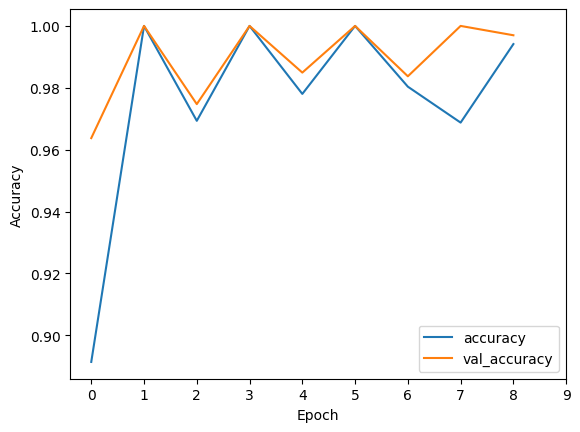

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")

plt.xticks(range(0, 10))

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

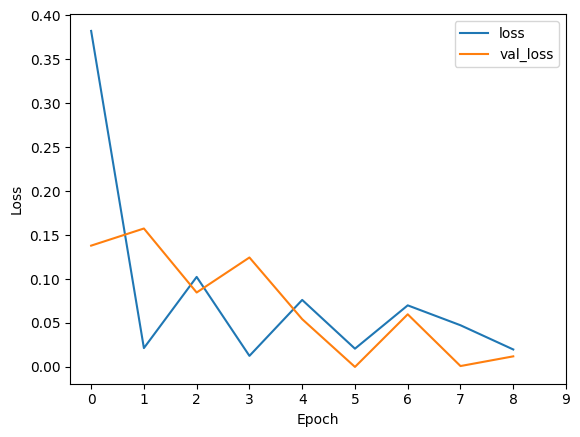

In [10]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")

plt.xticks(range(0, 10))

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


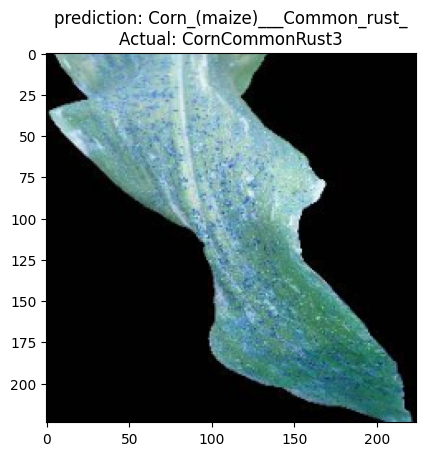

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


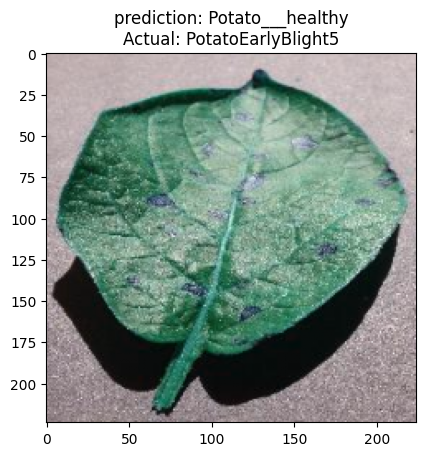

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


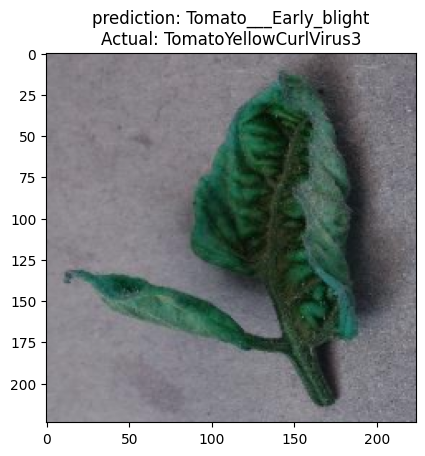

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


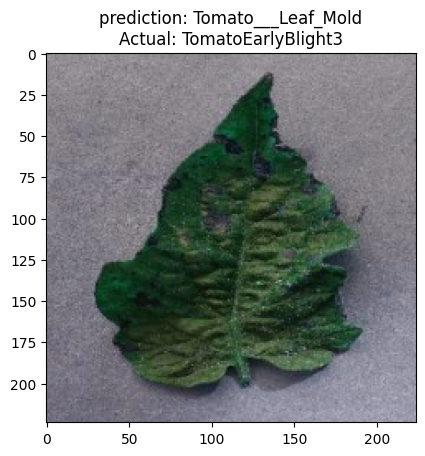

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


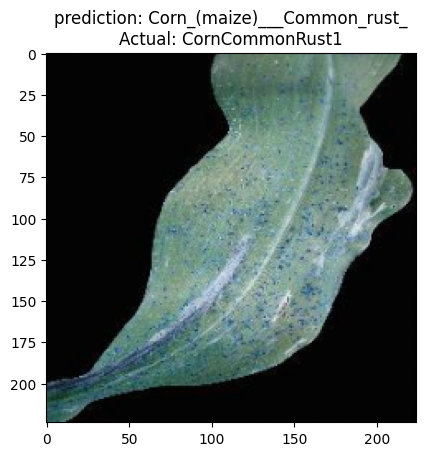

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


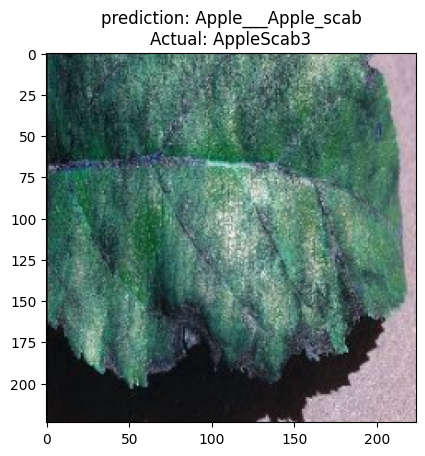

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


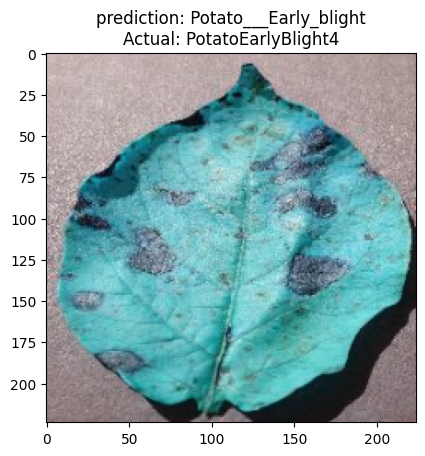

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


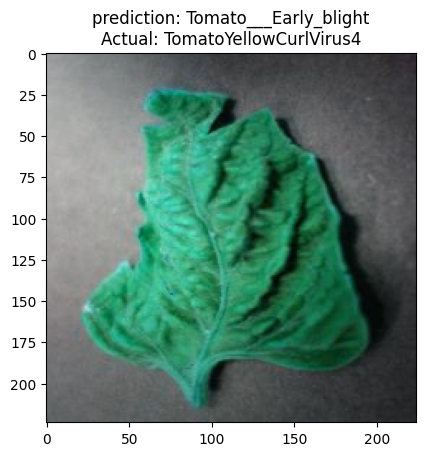

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


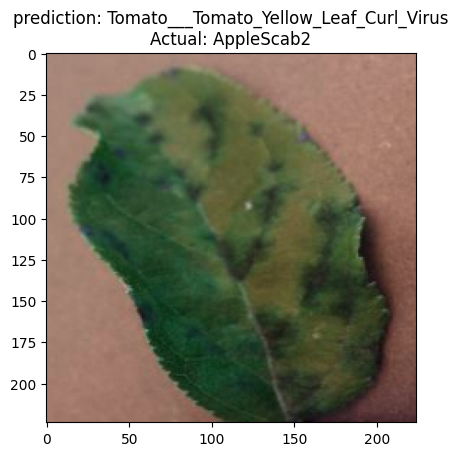

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


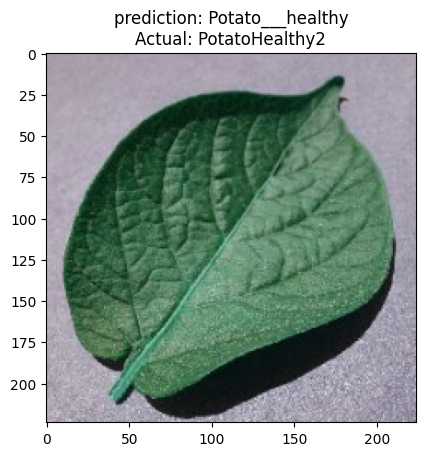

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


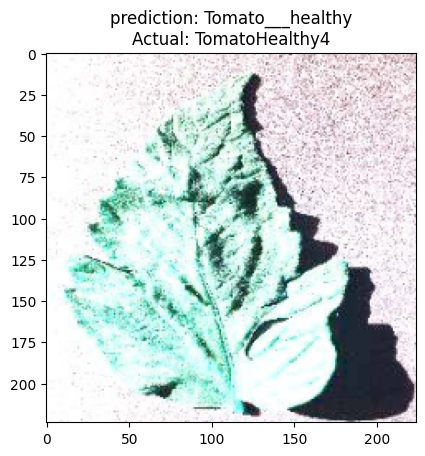

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


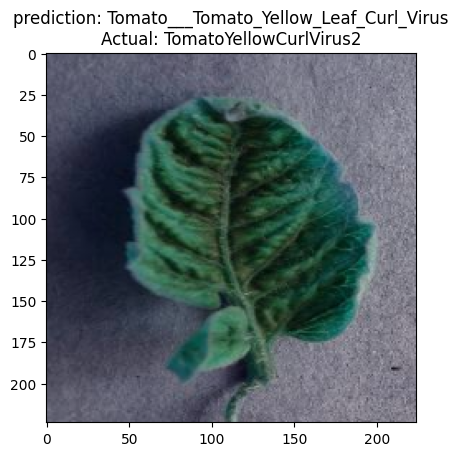

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


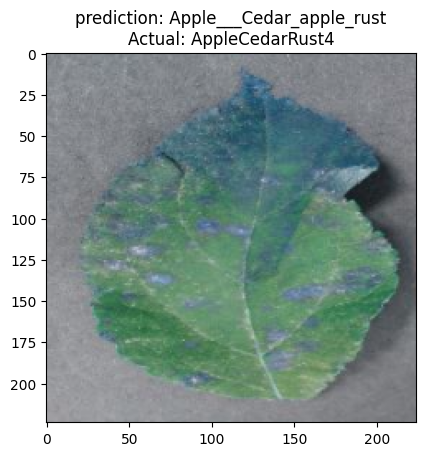

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


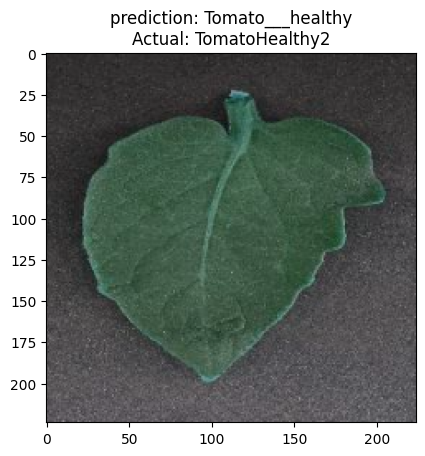

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


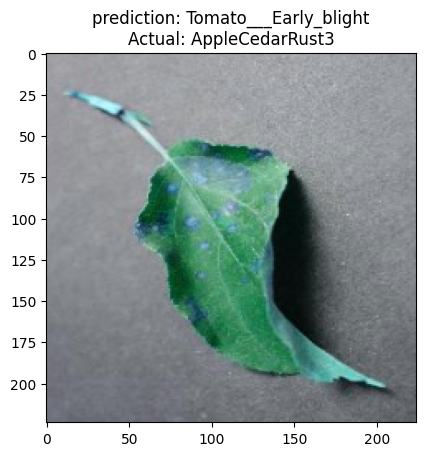

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


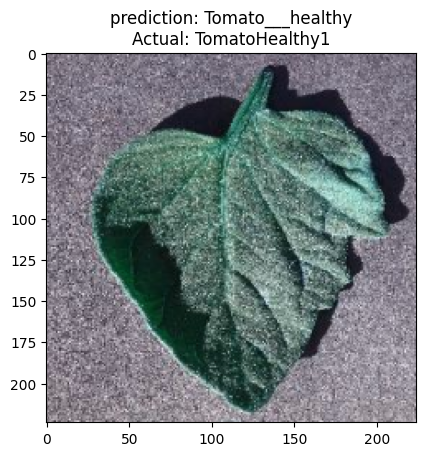

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


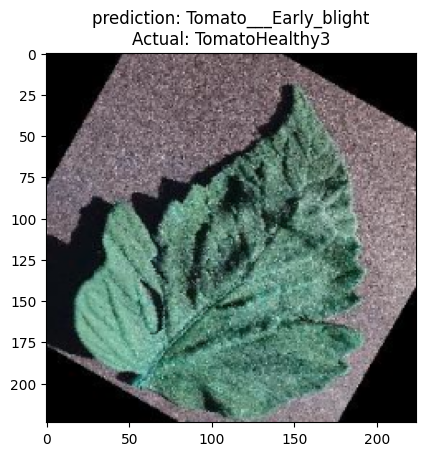

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


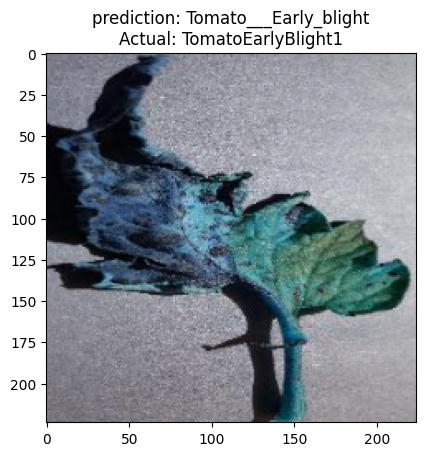

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


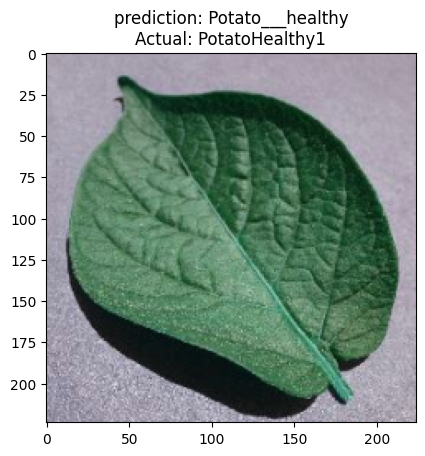

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


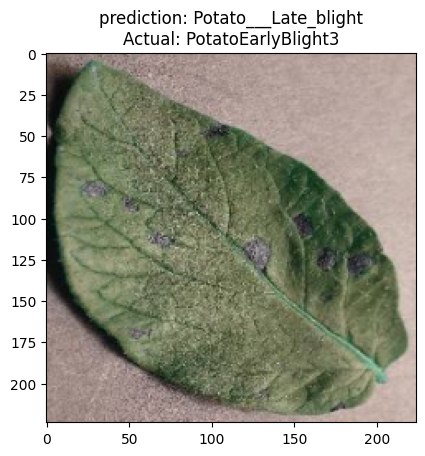

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


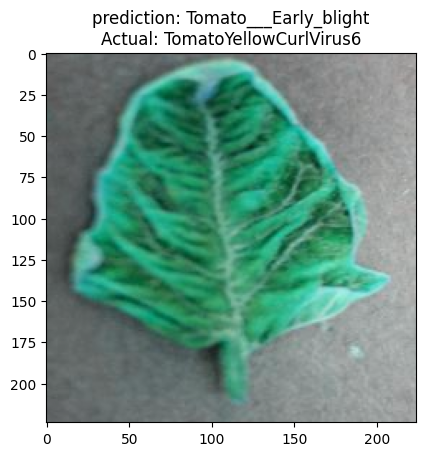

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


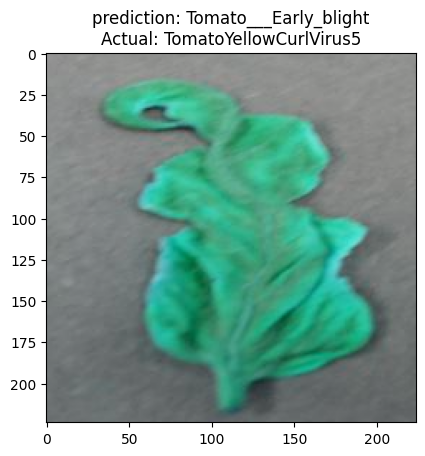

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


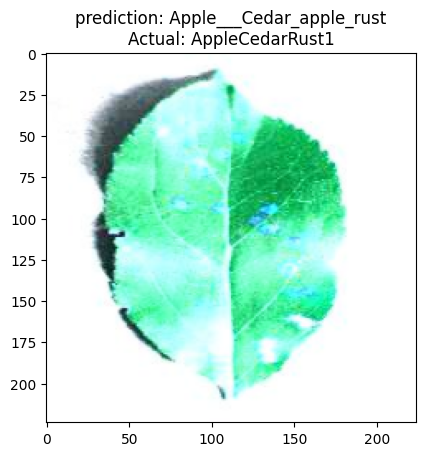

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


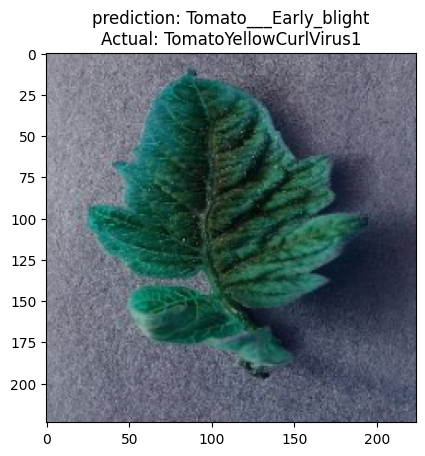

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


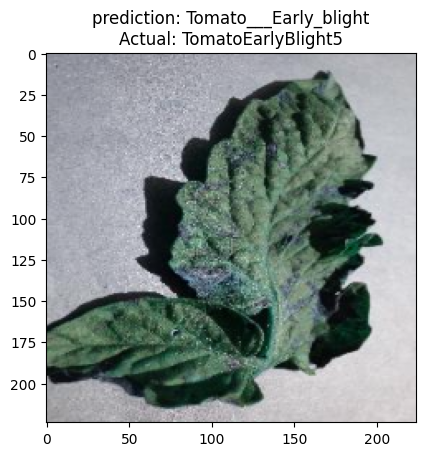

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


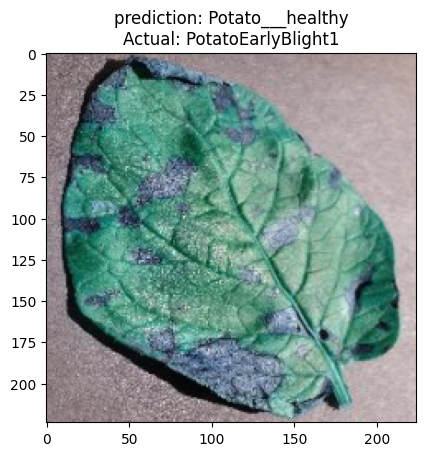

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


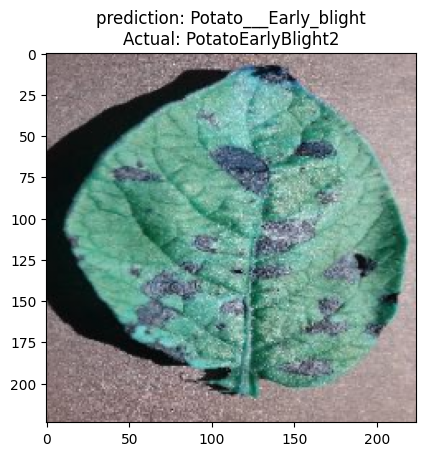

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


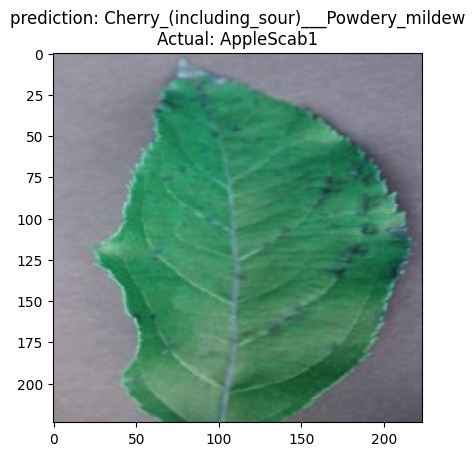

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


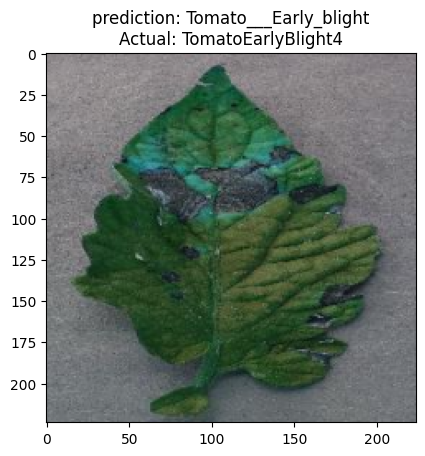

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


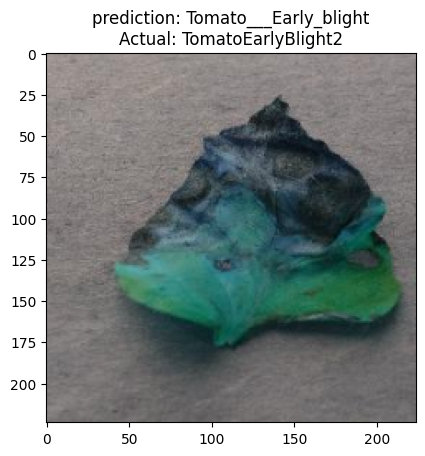

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


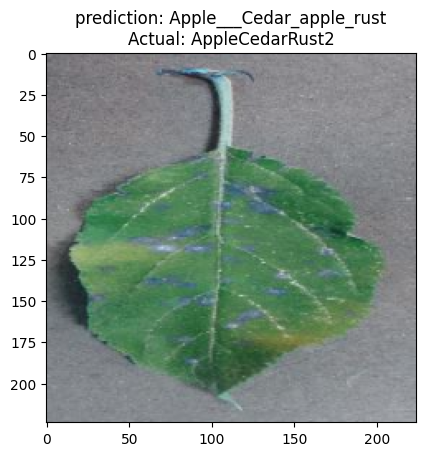

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


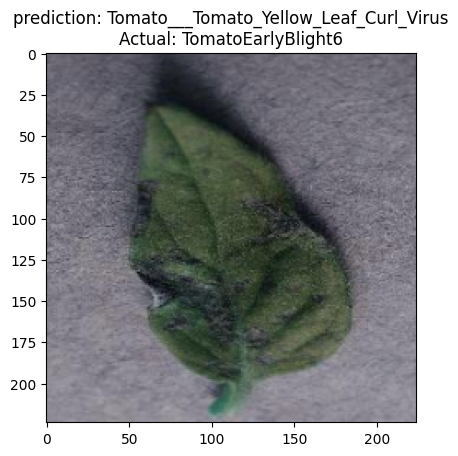

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


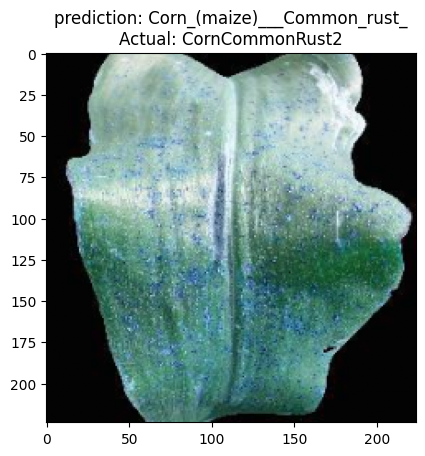

In [11]:
test = "/home/hany_jr/Ai/Plant-Diseases/dataset/test/test"

classes = train_generator.class_indices
classes = {v: k for k, v in classes.items()}

for i in os.listdir(test):
    img = cv2.imread(os.path.join(test, i))
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    prediction = model.predict(img)
    
    prediction = classes[np.argmax(prediction)]
    
    
    plt.imshow(img[0])
    plt.title("prediction: " + prediction + "\n" + "Actual: " + i.split(".")[0])
    plt.show()